> DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.

# Reference: Leveraging deep neural network foundation model features

In last week's project, you saw how important choosing the right features is to creating a successful ML model. For more complex modalities like vision, language, and speech, we didn't use the best features we could have! In project 3 we used standard baseline feature encodings for these modalities. In this notebook we introduce *foundation models*. These models can be trained on large, related datasets and from them we can extract general features for prediction tasks.

This notebook explores foundation models using an audio classification task. Along the way, you will learn to assess robustness of trained ML models by interacting with it and try to break them by using "adversarial examples". You will build and compile your models using scikit-learn and supporting tools.

Foundation models are often complex deep learning models trained with large datasets and many parameters. We provide pre-trained foundation models for use in this project. If you want to learn more about designing and training foundation models, check out the co:rise introduction to deep learning course!

### Instructions

0. **This notebook is optional**. You can read through the notebook to learn about foundation features, or make a copy and attempt some of the exercises/improvements yourself. The main project notebook for this week does not require any work/outputs from this notebook.
1. **Important:** If you run this notebook, you will need to turn on the GPU. In the top bar, click `Runtime`, and select `change runtime type`, and select `GPU`.
2. This notebook is interactive! You will get a chance to record yourself speaking and feed it as input to the model. If you do not have a good microphone, a few pre-recorded messages that you can listen to are provided as well.

In [ ]:
# check if you have enabled cpu
import torch
assert torch.cuda.is_available(), "GPU is unavailable. Did you change the runtime yet?"
print('GPU ready!')

GPU ready!


# Foundation Models

A ["foundation model"](https://arxiv.org/abs/2108.07258) is a large (often deep learning) model intended to act as feature extractors or a reusable partial model for multiple ML tasks in the same domain. Foundation models
are often trained on millions, if not billions of data points. Foundation models usually have multiple tasks/outputs (multi-task learning), with the intuition that a model which can predict many aspects of data will encode generally useful features.

We use foundation models to transform inputs for downstream usage. We use a foundation model $F$, to map an input $X$ to a $d$-dimensional vector $\mathbb{R}^d$. For example, if $d = 512$, then given a new example $x$, the output of $F(x)$ will be a 512-dimensional vector that we can treat as 512 new features to train your favorite supervised model for a regression or classification task.

### How do unsupervised/self-supervised models work?

This is broadly out of the scope of this course but to paint a high level picture: for unsupervised models, we have to define objective functions that do not use labels. These are often domain specific. Note that we call this "unsupervised", but the task is often classification and regression of easy to obtain labels (supervised learning formally). As a result, people sometimes use "self-supervised" as another way to refer to this sort of approach.

For example, in computer vision, popular methods take two random examples $x_1, x_2$ from the training dataset. Then compute two random crops of $x_1$ (call this $x_{1,1}$ and $x_{1, 2}$), and one random crop $x_2$ (call this $x_{2,1}$. Now, train a model to classify if $x_{1, 2}$ belongs to the same image as $x_{1,1}$ or $x_{2,1}$. Intuitively, this sounds like it should be really easy but is it? Two different crops of a large image may focus on different objects. For the model to do really well on this task, it must understand the structure of an image. What makes two objects likely to appear together? The model ends up learning semantic information about the objects inside.

For another example, in natural language, popular methods take a sentence and mask out a word. For example, *Hello, how are you?* becomes *Hello, [MASK] are you?*. The model's objective is to then classify which word `[MASK]` really is, out of all possible words in the vocabulary. If the model can do that, it again understands the structure of sentences enough to produce useful features.

These are rather high level descriptions of complex algorithms but we want to motivate the basic idea: unsupervised learning takes advantage of patterns in the data to create classification or regression tasks where the answer is known -- we don't need a human to annotate anything.

### From unsupervised models to foundation models

People quickly realized that if you take the best unsupervised models in a domain and train it at scale -- meaning using all the data on the internet for example -- then the features that the unsupervised model produces can be useful for a variety of prediction problems. For example, a foundation model in NLP might be useful for sentiment analysis, name entity recognition, and question answering at the same time!

The catch is that foundation models cannot solve these tasks out of the box -- they are just features! So the common practice is to train a small model on top of the foundation features to perform a specific task like sentiment analysis. Because the foundation features are so general, you typically do not need a very powerful model nor too much data to do any one specific task.

We will establish a baseline MVP model for an audio/speech classification task and then improve using foundation models.
The focus will be using off-the-shelf foundation models to derive features for a particular task, rather than the technical details of the foundation model. We will use what you have learned in the last three weeks about supervised learning and the speech domain to do this. Specifically, you will compare using foundation features to more traditional speech features like spectrogram features.

# Audio classification task

## Dependencies

We first setup the libraries requires for the project. Many of these may already be installed by default in Colab.

In [ ]:
!pip install numpy
!pip install scikit-learn
!pip install librosa
!pip install xgboost
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
from tqdm import tqdm
from collections import Counter

# importing a potpouri of models you can use
# feel free to add more!
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
import xgboost as xgb

## Dataset

We will working with a subset of [ERC-50](https://github.com/karolpiczak/ESC-50/blob/master/README.md) dataset for environmental sound classification. The dataset contains 2000 short audio recordings (5 second each) organized into 50 classes like `dog barking` or `baby crying`. Each class has 40 examples total. We will be working with a subset of 10 classes used in the ERC-10 corpus, an official subset of ERC-50.

In [ ]:
!gdown --id 1pSOZpkRWPGcW_7m43BoDLd7Qf0hhsQPO
!unzip -q -o ESC-50-master.zip

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1pSOZpkRWPGcW_7m43BoDLd7Qf0hhsQPO
To: /content/ESC-50-master.zip
100% 646M/646M [00:06<00:00, 93.2MB/s]


Let's take a look at the dataset folder contents.

In [ ]:
ls ESC-50-master/audio | head -4  # a bunch of audio clips as .wav files

1-100032-A-0.wav
1-100038-A-14.wav
1-100210-A-36.wav
1-100210-B-36.wav


In [ ]:
# Load annotations. Here are the relevant columns!
#   - filename = this is the local name of the audio file for the row
#   - target = this is the label index (out of 50 difference classes)
data = pd.read_csv('ESC-50-master/meta/esc50.csv')
print(f'# of rows: {len(data)}')

data.head()

# of rows: 2000


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [ ]:
# To simplify the task, we will only take 10 of the 50 classes
# These 10 classes are from ESC-10 (a 10 class subset of ESC-50).
category = [
  'dog',
  'rain',
  'sea_waves',
  'crying_baby',
  'clock_tick',
  'sneezing',
  'helicopter',
  'chainsaw',
  'rooster',
  'crackling_fire',
]
data = data[data.category.isin(category)]

# we need to remap these labels to be from 0->10
old_labels = [
  data[data.category == c].iloc[0].target for c in category]
label_map = dict(zip(old_labels, np.arange(len(data.target))))
data['target'] = data.target.apply(lambda x: label_map[x])

<ipython-input-7-5e1a9794126c>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data.target.apply(lambda x: label_map[x])


In [ ]:
# the total is organized with folds (we will talk more about this later).
# We can train on 4 of the folds and test on the remaining fold.
data_train = data[data['fold'] > 1]  # use the first fold as test
data_test = data[data['fold'] == 1]

print(f'train # of rows: {len(data_train)}')
print('train # per class:')
print(Counter(data_train['target'].to_numpy()))
print(f'test # of rows: {len(data_test)}')
print('test # per class:')
print(Counter(data_test['target'].to_numpy()))

train # of rows: 320
train # per class:
Counter({8: 32, 1: 32, 2: 32, 3: 32, 5: 32, 0: 32, 4: 32, 9: 32, 6: 32, 7: 32})
test # of rows: 80
test # per class:
Counter({0: 8, 7: 8, 9: 8, 6: 8, 1: 8, 3: 8, 4: 8, 5: 8, 8: 8, 2: 8})


This is quite a small dataset! There are 40 examples per class (32 of them for training and 8 of them for evaluation) -- a total of 400 examples.

It is exactly in these low-data settings that foundation models can be helpful since its features have been trained on a much larger corpus of potentially relevant data. These features distill useful information from the audio signal for a supervised classifier we train downstream.

In [ ]:
from sklearn.model_selection import train_test_split

class BaseDataset:
  """
  We will use this base class for all datasets.
  You do not need to change this class.
  """
  def __init__(self):
    self._data = self.make_data()

  def _load(self):
    raise NotImplementedError

  def make_data(self):
    print('loading data...')
    X_train, y_train = self._load()
    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, shuffle=True)
    print('done.')
    return dict(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test)

  def get_train_data(self):
    return self._data['X_train'], self._data['y_train']

  def get_test_data(self):
    return self._data['X_test'], self._data['y_test']

  @property
  def num_train(self):
    return len(self._data['X_train'])

  @property
  def num_test(self):
    return len(self._data['X_test'])

In [ ]:
from os.path import join


class ERC10Dataset(BaseDataset):
  CATEGORIES = [
    'dog',
    'rain',
    'sea_waves',
    'crying_baby',
    'clock_tick',
    'sneezing',
    'helicopter',
    'chainsaw',
    'rooster',
    'crackling_fire',
  ]

  def __init__(self, test_fold=1):
    self._test_fold = test_fold
    super().__init__()

  def make_data(self):
    """
    Overload BaseDataset's `make_data` file.
    """
    data_path = 'ESC-50-master/meta/esc50.csv'
    audio_path = 'ESC-50-master/audio'
    data = pd.read_csv(data_path)
    data = data[data.category.isin(self.CATEGORIES)]
    old_labels = [
      data[data.category == c].iloc[0].target for c in self.CATEGORIES]
    label_map = dict(zip(old_labels, np.arange(len(data.target))))
    data.target = data.target.apply(lambda x: label_map[x])
    data_train = data[data['fold'] != self._test_fold]
    data_test = data[data['fold'] == self._test_fold]

    # the X_train and X_test objects only contain filenames,
    # not audio data or spectrograms
    X_train = data_train['filename'].apply(
        lambda x: join(audio_path, x)).to_numpy()
    X_test = data_test['filename'].apply(
        lambda x: join(audio_path, x)).to_numpy()

    y_train = data_train['target'].to_numpy()
    y_test = data_test['target'].to_numpy()

    return dict(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test)


dataset = ERC10Dataset(test_fold=1)
X_train, y_train = dataset.get_train_data()
X_test, y_test = dataset.get_test_data()

print('First 5 training files:')
print(X_train[:5])
print('First 5 training labels:')
print(y_train[:5])

First 5 training files:
['ESC-50-master/audio/2-100786-A-1.wav'
 'ESC-50-master/audio/2-101676-A-10.wav'
 'ESC-50-master/audio/2-102852-A-11.wav'
 'ESC-50-master/audio/2-107351-A-20.wav'
 'ESC-50-master/audio/2-107351-B-20.wav']
First 5 training labels:
[8 1 2 3 3]


## Baseline

Let's first use the strategy from last week's projects to feature speech data as average log mel spectrograms, and fit a linear SVM on top. You are free to explore other models and hyperparameters to get this baseline to be as strongly performing as it can be.

In [ ]:
from tqdm import tqdm

def traditional_feature_fn(
  data, sr=16000, transform_fn=None, transform_kwargs={}):
  # Compute averaged log-mel spectrograms.
  features = []
  pbar = tqdm(total=len(data), position=0, leave=True)
  for audio in data:
    if transform_fn is not None:    # ignore this until robustness expts
      audio = transform_fn(audio, sr, **transform_kwargs)
    wav_mel = librosa.feature.melspectrogram(
      y=audio, sr=sr, hop_length=512)
    feats = np.log(wav_mel + 1e-7)  # add epsilon to prevent errors
    feats = librosa.util.normalize(feats)
    feats = feats.mean(1)
    features.append(feats)
    pbar.update()
  pbar.close()
  features = np.stack(features)
  return features

In [ ]:
# helpful utility to load audio files
def load_audio(paths):
  data = []
  pbar = tqdm(total=len(paths), position=0, leave=True)
  for path in paths:
    audio, sr = librosa.load(path, sr=16000)
    data.append(audio)
    pbar.update()
  pbar.close()
  data = np.stack(data)
  return data, sr

## K-fold cross validation

You may have noticed there are 5 different folds and in training the dataset, and that we arbitrarily chose to use the first fold as the test set.

In practice, we often want to the confirm the model does well across many different train and test splits. One strategy is called $k$-fold cross validation where we loop through $k$ folds, treating each one as a test set and training on the remaining $k-1$. This results in $k$ different models and $k$ different performance metrics. The true performance of the system is estimated by the average over $k$ folds!

In [ ]:
def kfold_pipeline(feature_fn, train_fn, predict_fn, verbose=True):
  """
  Generic pipeline for 5-fold evaluation on ERC10Dataset.

  @feature_fn: takes as input a numpy array of input columns
  @train_fn: takes as input two numpy arrays of features and labels
  @predict_fn: takes as input a numpy array of input columns
  """
  eval_train = []
  eval_test = []
  models = []

  for test_fold in [1, 2, 3, 4, 5]:
    if verbose:
      print(f'-- Starting fold: {test_fold}')

    dataset = ERC10Dataset(test_fold=test_fold)
    X_train, y_train = dataset.get_train_data()
    X_test, y_test = dataset.get_test_data()

    X_train, sr = load_audio(X_train)  # load from files
    X_test, _ = load_audio(X_test)     # load from files

    Xf_train = feature_fn(X_train, sr=sr)
    Xf_test = feature_fn(X_test, sr=sr)

    model = train_fn(Xf_train, y_train)
    yhat_train = predict_fn(model, Xf_train)
    yhat_test = predict_fn(model, Xf_test)

    acc_train = accuracy_score(y_train, yhat_train)
    acc_test = accuracy_score(y_test, yhat_test)

    eval_train.append(acc_train)
    eval_test.append(acc_test)
    models.append(model)

    if verbose:
      print(f'---- test acc: {acc_test}')

  results = dict(
      train_acc_avg=np.mean(eval_train),
      train_acc_std=np.std(eval_train),
      test_acc_avg=np.mean(eval_test),
      test_acc_std=np.std(eval_test),
  )
  return results, models

In [ ]:
def train_svm(X_train, y_train):
  model = LinearSVC()
  model.fit(X_train, y_train)
  return model

def predict_svm(model, X):
  return model.predict(X)

results, models = kfold_pipeline(traditional_feature_fn, train_svm, predict_svm)
print(f'Train Accuracy: {results["train_acc_avg"]} +- {results["train_acc_std"]}')
print(f'Test Accuracy: {results["test_acc_avg"]} +- {results["test_acc_std"]}')

-- Starting fold: 1


100%|██████████| 80/80 [00:00<00:00, 95.06it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---- test acc: 0.575
-- Starting fold: 2


100%|██████████| 80/80 [00:00<00:00, 88.81it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---- test acc: 0.6375
-- Starting fold: 3


100%|██████████| 80/80 [00:00<00:00, 89.11it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---- test acc: 0.6125
-- Starting fold: 4


100%|██████████| 80/80 [00:00<00:00, 95.14it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---- test acc: 0.75
-- Starting fold: 5


100%|██████████| 80/80 [00:00<00:00, 86.63it/s]


---- test acc: 0.6625
Train Accuracy: 0.8425 +- 0.009185586535436928
Test Accuracy: 0.6475000000000001 +- 0.0588430114796991


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Notice the natural variance across folds can be very high. That's why k-fold validation can be very useful: it gives a more faithful depiction of model performance.

### **Optional Task: Improve upon baseline via model selection**

Try a few different models! See if you can find one that performs better than the SVM. Use the `kfold_pipeline`. Make sure you define a `train_fn` and a `predict_fn` for your model. Report performance for your best model.

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

#############################

## Interacting with your model

To experiment with how general/robust a model is, you can try it with your own voice! One of the classes is `sneeze`. The teaching staff kindly recorded some  (fake) sneezing just for you to use as an example!


In [ ]:
!gdown --id 1-3bZfXq-moMG2XBSljYQEbWX97ZFAxS-

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-3bZfXq-moMG2XBSljYQEbWX97ZFAxS-
To: /content/mysneeze.wav
100% 502k/502k [00:00<00:00, 144MB/s]


In [ ]:
from IPython.display import Audio
Audio('./mysneeze.wav')  # I tried my best to fake sneeze

In [ ]:
label_categories = ERC10Dataset(test_fold=1).CATEGORIES
print(label_categories)
print(f'Sneezing has label {label_categories.index("sneezing")}.')  # 0 indexed!

['dog', 'rain', 'sea_waves', 'crying_baby', 'clock_tick', 'sneezing', 'helicopter', 'chainsaw', 'rooster', 'crackling_fire']
Sneezing has label 5.


We will build a pipeline to make predictions given a trained model.

In [ ]:
def inference_pipeline(feature_fn, models, X, sr=16000, **kwargs):
  """
  Generic pipeline for making predictions on new examples X.

  @feature_fn: takes as input a numpy array of input columns
  @models: List of scikit-learn models from k-fold validation.
  @X: np array of examples, must be two-dimensional
      shape: # of examples x # of features
  """

  # since we have 5 models from cross-validation, we can make
  # a bagged ensemble! Each model is diverse since it is trained
  # on a different split.
  Xf = feature_fn(X, sr=sr, **kwargs)  # compute features
  yhat_votes = []
  for model in models:
    yhat = model.predict(Xf)  # compute predictions
    yhat_votes.append(yhat)
  yhat_votes = np.stack(yhat_votes).T  # N x num models
  yhat_final = []
  for i in range(yhat_votes.shape[0]):
    # compute majority
    majority_vote = Counter(yhat_votes[i]).most_common()[0][0]
    yhat_final.append(majority_vote)
  return np.array(yhat_final)

In [ ]:
X = np.array(['./mysneeze.wav'])
X, sr = load_audio(X)
yhat = inference_pipeline(traditional_feature_fn, models, X, sr=sr)
print(f'\nModel predicted: {label_categories[yhat[0]]}.')

100%|██████████| 1/1 [00:00<00:00, 91.81it/s]



Model predicted: clock_tick.


Using our baseline model, the sneeze is confused for a clock tick! Creating or discovering test cases is a useful way to probe for areas where your model gets confused. This sort of testing is critical when deploying real world systems for complex tasks.

Te baseline model's performance is around 63%, which is not high enough for real world usage. How can we improve performance? This is where foundation models will come in.

### **Optional Task: Try your own test audio!**



You can record yourself sneezing and see if the model can correctly classify the audio clip. Make sure make it less than 5 seconds long. You can also find/record an audio clip of other sounds to test the model.

Convert the audio file to a `.wav` file if it is not already. I recommend this [service](https://cloudconvert.com/m4a-to-wav) for file conversions.

To use the file in Colab: Upload it to a Google Drive, create a public link, and change the `id` below to the one in your link.

For example, if your google link is:
```
https://drive.google.com/file/d/1-3bZfXq-moMG2XBSljYQEbWX97ZFAxS-/view?usp=sharing
```
then the id would be `1-3bZfXq-moMG2XBSljYQEbWX97ZFAxS-`.

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

#############################

What your model correct? If not, why do you think that is? What are some possibel sources of error? For example, do you think your microphone was the same as the recordings in the dataset?  

If you find the model fairly brittle, see if you can create/find examples that **are correctly classified** with your model. You might find that the system is quite narrow in its coverage compared with all the possible variations of environment noises.

(Insert your answer here.)

# How robust is your model?

High accuracy is one property of a model that we might care about but it is only one! Another very important property is **robustness**. Data in the real world is noisy and often riddled with small blemishes not encountered in the training or development sets. How resilient is the model to such perturbations? For example, if someone speaks with an accent or has a naturally loud voice, is the model still able to retain a high accuracy?

This concept of robustness is worth emphasizing again. In practice, we would often trade a bit of accuracy for higher robustness. We really want our models to work all the time.

Below, let's try to test our model for robustness. To simulate this, we can take the test set and apply a series of transformations e.g. increase volume, or change pitch, and see how the performance changes with varying levels of transformations. A more robust model would degrade slower as transformations grow more severe.

In [ ]:
def transform_pitch(audio_input, sample_rate, strength=1):
  audio_output = librosa.effects.pitch_shift(
      audio_input, sample_rate, n_steps=strength)
  return audio_output

def transform_speed(audio_input, sample_rate, strength=1):
  audio_output_ = librosa.effects.time_stretch(
      audio_input, strength)
  audio_output = np.zeros_like(audio_input)
  new_length = min(len(audio_output), len(audio_output_))
  audio_output[:new_length] = audio_output_[:new_length]
  return audio_output

def transform_volume(audio_input, sample_rate, strength=1):
  audio_output = audio_input * strength
  return audio_output

def transform_noise(audio_input, sample_rate, strength=1):
  noise = 0.005 * np.random.normal(size=audio_input.shape[0]) * strength
  audio_output = audio_input + noise
  return audio_output

def transform_samplerate(audio_input, sample_rate, target_sr=1600):
  audio_output = librosa.resample(audio_input, sr, target_sr, res_type='linear',
                                  fix=True)
  return audio_output



In [ ]:
def show_spectrogram(audio_input, sample_rate):
  S = librosa.feature.melspectrogram(y=audio_input, sr=sample_rate, n_mels=128,
                                    fmax=8000)
  fig, ax = plt.subplots()
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                           y_axis='mel', sr=sample_rate,
                           fmax=8000, ax=ax)
  fig.colorbar(img, ax=ax, format='%+2.0f dB')
  ax.set(title='Mel-frequency spectrogram')

### Examples of perturbed data

Let's play with these transforms a bit to build intuition.

In [ ]:
from IPython.display import Audio

demo_example = './ESC-50-master/audio/1-30226-A-0.wav'  # dog barking
demo_audio, demo_sr = librosa.load(demo_example, sr=16000)

In [ ]:
Audio(demo_example)

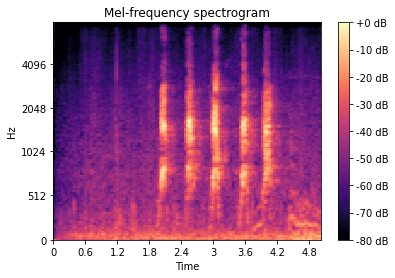

In [ ]:
show_spectrogram(demo_audio, demo_sr)

In [ ]:
demo_transformed = transform_pitch(demo_audio, demo_sr, strength=10)
Audio(data=demo_transformed, rate=demo_sr)  # high pitch!

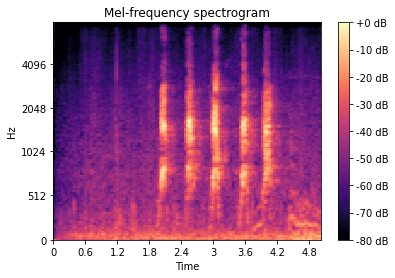

In [ ]:
show_spectrogram(demo_audio, demo_sr)

In [ ]:
demo_transformed = transform_pitch(demo_audio, demo_sr, strength=-10)
Audio(data=demo_transformed, rate=demo_sr)  # low pitch!

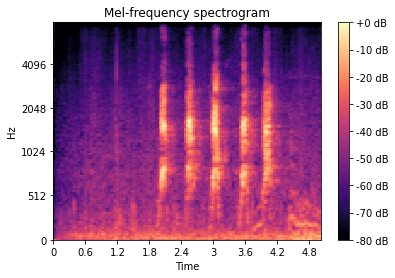

In [ ]:
show_spectrogram(demo_audio, demo_sr)

In [ ]:
demo_transformed = transform_speed(demo_audio, demo_sr, strength=2)
Audio(data=demo_transformed, rate=demo_sr)  # fast speed!

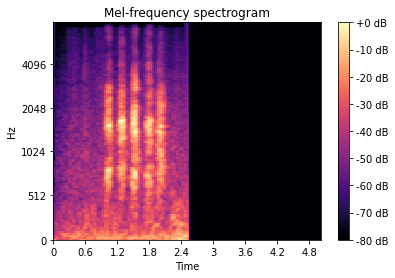

In [ ]:
show_spectrogram(demo_transformed, demo_sr)

In [ ]:
demo_transformed = transform_speed(demo_audio, demo_sr, strength=0.5)
Audio(data=demo_transformed, rate=demo_sr)  # slow speed!

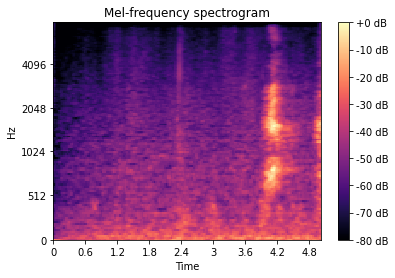

In [ ]:
show_spectrogram(demo_transformed, demo_sr)

In [ ]:
demo_lowvol = transform_volume(demo_audio, demo_sr, strength=0.5)
demo_highvol = transform_volume(demo_audio, demo_sr, strength=2)

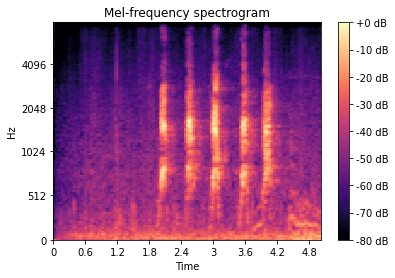

In [ ]:
show_spectrogram(demo_lowvol, demo_sr)

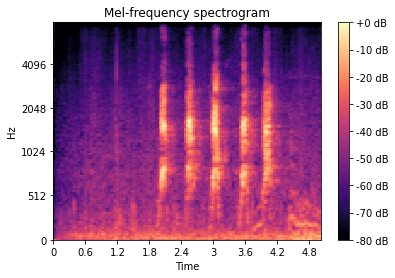

In [ ]:
show_spectrogram(demo_highvol, demo_sr)

In [ ]:
demo_transformed = transform_noise(demo_audio, demo_sr, strength=10)
Audio(data=demo_transformed, rate=demo_sr)  # noisy!

In [ ]:
demo_noise10 = transform_noise(demo_audio, demo_sr, strength=10)
demo_noise30 = transform_noise(demo_audio, demo_sr, strength=30)

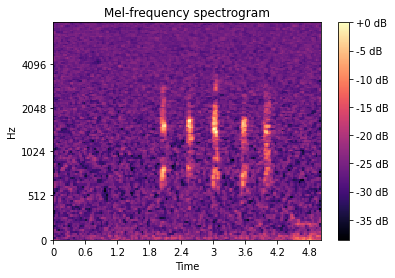

In [ ]:
show_spectrogram(demo_noise10, demo_sr)

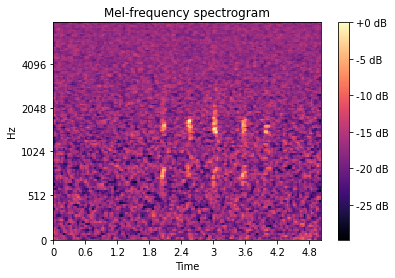

In [ ]:
show_spectrogram(demo_noise30, demo_sr)

### Evaluating performance on perturbed data

We can build a test framework to try several values for each perturbation. This will allow us to more systematically explore how model performance varies in different conditions.

In [ ]:
class EvalRobustness:
  """
  Evaluates a scikit-learn speech model using several robustness
  tests for pitch, speed, volume, and noise.
  """

  def __init__(self, model, waveforms, labels, feature_fn, sr=16000):
    self._model = model  # already trained
    self._waveforms = waveforms
    self._labels = labels
    # this feature function will loop through all daata and
    # compute features e.g. `traditional_feature_fn`.
    self._feature_fn = feature_fn
    self._sr = sr

  def _base_test(self, name, strengths, transform_fn):
    metrics = []
    for strength in strengths:
      print(f'running {name} robustness test - strength: {strength}')
      # compute features over all data; transform_fn is applied in _feature_fn
      feats = self._feature_fn(
        self._waveforms, sr=self._sr, transform_fn=transform_fn,
        transform_kwargs={'strength': strength})
      yhat = self._model.predict(feats)
      acc_transformed = accuracy_score(self._labels, yhat)
      metrics.append(acc_transformed)
    return strengths, metrics

  def test_pitch(self):
    strengths = [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]
    return self._base_test('pitch', strengths, transform_pitch)

  def test_speed(self):
    strengths = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
    return self._base_test('speed', strengths, transform_speed)

  def test_volume(self):
    strengths = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
    return self._base_test('volume', strengths, transform_volume)

  def test_noise(self):
    strengths = [1, 2, 5, 10, 20, 30, 40, 50]
    return self._base_test('noise', strengths, transform_noise)

Let's test the robustness of the first SVM model (using the first fold for testing).

In [ ]:
dataset = ERC10Dataset(test_fold=1)
X_test, y_test = dataset.get_test_data()
X_test, sr = load_audio(X_test)
evaluator = EvalRobustness(models[0], X_test, y_test, traditional_feature_fn)

100%|██████████| 80/80 [00:13<00:00,  6.06it/s]


In [ ]:
pitch_strengths, svm_pitch_acc = evaluator.test_pitch()
speed_strengths, svm_speed_acc = evaluator.test_speed()
volume_strengths, svm_volume_acc = evaluator.test_volume()
noise_strengths, svm_noise_acc = evaluator.test_noise()

running pitch robustness test - strength: -10


100%|██████████| 80/80 [00:12<00:00,  6.35it/s]


running pitch robustness test - strength: -8


100%|██████████| 80/80 [00:13<00:00,  5.79it/s]


running pitch robustness test - strength: -6


100%|██████████| 80/80 [00:12<00:00,  6.25it/s]


running pitch robustness test - strength: -4


100%|██████████| 80/80 [00:13<00:00,  6.14it/s]


running pitch robustness test - strength: -2


100%|██████████| 80/80 [00:13<00:00,  6.14it/s]


running pitch robustness test - strength: 0


100%|██████████| 80/80 [00:06<00:00, 12.91it/s]


running pitch robustness test - strength: 2


100%|██████████| 80/80 [00:13<00:00,  5.96it/s]


running pitch robustness test - strength: 4


100%|██████████| 80/80 [00:14<00:00,  5.48it/s]


running pitch robustness test - strength: 6


100%|██████████| 80/80 [00:15<00:00,  5.08it/s]


running pitch robustness test - strength: 8


100%|██████████| 80/80 [00:17<00:00,  4.59it/s]


running pitch robustness test - strength: 10


100%|██████████| 80/80 [00:18<00:00,  4.42it/s]


running speed robustness test - strength: 0.1


100%|██████████| 80/80 [00:29<00:00,  2.75it/s]


running speed robustness test - strength: 0.25


100%|██████████| 80/80 [00:14<00:00,  5.37it/s]


running speed robustness test - strength: 0.5


100%|██████████| 80/80 [00:08<00:00,  9.01it/s]


running speed robustness test - strength: 0.75


100%|██████████| 80/80 [00:07<00:00, 10.91it/s]


running speed robustness test - strength: 1.0


100%|██████████| 80/80 [00:05<00:00, 15.39it/s]


running speed robustness test - strength: 1.25


100%|██████████| 80/80 [00:05<00:00, 14.01it/s]


running speed robustness test - strength: 1.5


100%|██████████| 80/80 [00:03<00:00, 21.28it/s]


running speed robustness test - strength: 1.75


100%|██████████| 80/80 [00:03<00:00, 20.71it/s]


running speed robustness test - strength: 2.0


100%|██████████| 80/80 [00:04<00:00, 19.57it/s]


running volume robustness test - strength: 0.1


100%|██████████| 80/80 [00:00<00:00, 93.51it/s]


running volume robustness test - strength: 0.25


100%|██████████| 80/80 [00:00<00:00, 91.48it/s]


running volume robustness test - strength: 0.5


100%|██████████| 80/80 [00:00<00:00, 91.41it/s]


running volume robustness test - strength: 0.75


100%|██████████| 80/80 [00:00<00:00, 90.27it/s]


running volume robustness test - strength: 1.0


100%|██████████| 80/80 [00:00<00:00, 87.33it/s]


running volume robustness test - strength: 1.25


100%|██████████| 80/80 [00:00<00:00, 91.86it/s]


running volume robustness test - strength: 1.5


100%|██████████| 80/80 [00:00<00:00, 88.98it/s]


running volume robustness test - strength: 1.75


100%|██████████| 80/80 [00:00<00:00, 93.37it/s]


running volume robustness test - strength: 2.0


100%|██████████| 80/80 [00:00<00:00, 91.82it/s]


running noise robustness test - strength: 1


100%|██████████| 80/80 [00:02<00:00, 32.42it/s]


running noise robustness test - strength: 2


100%|██████████| 80/80 [00:01<00:00, 48.72it/s]


running noise robustness test - strength: 5


100%|██████████| 80/80 [00:01<00:00, 57.10it/s]


running noise robustness test - strength: 10


100%|██████████| 80/80 [00:01<00:00, 54.62it/s]


running noise robustness test - strength: 20


100%|██████████| 80/80 [00:01<00:00, 55.72it/s]


running noise robustness test - strength: 30


100%|██████████| 80/80 [00:01<00:00, 56.47it/s]


running noise robustness test - strength: 40


100%|██████████| 80/80 [00:01<00:00, 56.42it/s]


running noise robustness test - strength: 50


100%|██████████| 80/80 [00:01<00:00, 56.55it/s]


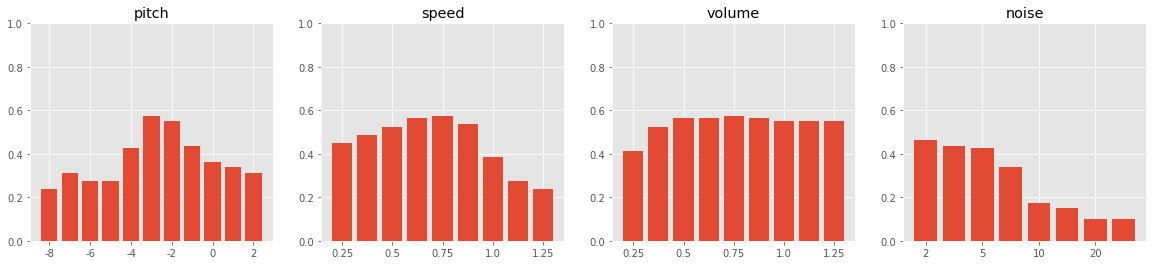

In [ ]:
plt.style.use('ggplot')

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
axs[0].bar(range(len(pitch_strengths)), svm_pitch_acc, label='pitch')
axs[1].bar(range(len(speed_strengths)), svm_speed_acc, label='speed')
axs[2].bar(range(len(volume_strengths)), svm_volume_acc, label='volume')
axs[3].bar(range(len(noise_strengths)), svm_noise_acc, label='noise')
axs[0].set_xticklabels(pitch_strengths)
axs[1].set_xticklabels(speed_strengths)
axs[2].set_xticklabels(volume_strengths)
axs[3].set_xticklabels(noise_strengths)
axs[0].set_title('pitch')
axs[1].set_title('speed')
axs[2].set_title('volume')
axs[3].set_title('noise')
axs[0].set_ylim(0, 1)
axs[1].set_ylim(0, 1)
axs[2].set_ylim(0, 1)
axs[3].set_ylim(0, 1)
plt.show()

These plots show accuracy for each perturbation setting we evaluated. Which transformations are the model more sensitive to and which are the model less sensitive to? For the ones the model seems to do well across, why do you think that is? (You can practice summarizing model performance as if you were conferrring with peers about whether the model is ready for production usage)


# Foundation Model Features

Next we are going to try a foundation models for speech: [HUBERT](https://arxiv.org/abs/2106.07447). This foundation model uses large neural networks called Transformers that are trained on large speech corpora with clever unsupervised objectives. We will use a trained model to transform our features, but not go into HUBERT itself. Let's try to improve on our sound classification task!

In [ ]:
!pip install transformers
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
@torch.no_grad()
def speech_foundation_feature_fn(
  data, processor, model, sr=16000, transform_fn=None,
  transform_kwargs={}, device=None):
  """
  General tool for getting features. Supports minibatching and GPU
  casting. You can ignore the details of this function -- it computes
  foundation features for every entry in the `data` array.
  """
  if device is None:
    device = torch.device('cpu')
  # replaces the `get_traditional_features` function!
  features = []
  pbar = tqdm(total=len(data), position=0, leave=True)
  batch_size = 32
  minibatch = []
  for audio in data:
    if transform_fn is not None:    # ignore this until robustness expts
      audio = transform_fn(audio, sr, **transform_kwargs)

    if len(minibatch) == batch_size:
      minibatch = np.stack(minibatch)
      input_values = processor(
        minibatch, sampling_rate=sr, return_tensors="pt").input_values
      input_values = input_values.squeeze(0)
      input_values = input_values.to(device)
      # mean over `sequence_length`
      feats = model(input_values).last_hidden_state.mean(1)
      feats = feats.detach().cpu().numpy()
      features.append(feats)
      minibatch = [audio]
    else:
      minibatch.append(audio)
    pbar.update()
  pbar.close()

  if len(minibatch) > 0:  # compute residuals
    minibatch = np.stack(minibatch)
    input_values = processor(
      minibatch, sampling_rate=sr, return_tensors="pt").input_values
    input_values = input_values.squeeze(0)
    input_values = input_values.to(device)
    # mean over `sequence_length`
    feats = model(input_values).last_hidden_state.mean(1)
    feats = feats.detach().cpu().numpy()
    features.append(feats)
  features = np.concatenate(features, axis=0)
  return features

In [ ]:
import torch
from transformers import Wav2Vec2Processor, HubertModel

device = torch.device('cuda')  # make sure GPU hardware is enabled!
hubert_processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
hubert_model = HubertModel.from_pretrained("facebook/hubert-large-ls960-ft")
hubert_model = hubert_model.to(device)

def hubert_feature_fn(data, sr=16000, transform_fn=None, transform_kwargs={}):
  features = speech_foundation_feature_fn(
      data, hubert_processor, hubert_model, sr=sr, transform_fn=transform_fn,
      transform_kwargs=transform_kwargs, device=device)
  return features

Some weights of the model checkpoint at facebook/hubert-large-ls960-ft were not used when initializing HubertModel: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Train and evaluate using HUBERT features

Using the same `train` and `predict` function definition approach above, this example runs the `kfold_pipeline` function to train and evaluate using HUBERT features and a `LinearSVC` classifier.

In [ ]:
def train_svm(X_train, y_train):
  model = LinearSVC()
  model.fit(X_train, y_train)
  return model

def predict_svm(model, X):
  return model.predict(X)

# this will take 5-7 minutes to run
results, models = kfold_pipeline(hubert_feature_fn, train_svm, predict_svm)

print(f'[HUBERT+SVM] Train Accuracy: {results["train_acc_avg"]} +- {results["train_acc_std"]}')
print(f'[HUBERT+SVM] Test Accuracy: {results["test_acc_avg"]} +- {results["test_acc_std"]}')

-- Starting fold: 1


100%|██████████| 80/80 [00:03<00:00, 23.20it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---- test acc: 0.8375
-- Starting fold: 2


100%|██████████| 80/80 [00:03<00:00, 22.00it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---- test acc: 0.875
-- Starting fold: 3


100%|██████████| 80/80 [00:03<00:00, 20.89it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---- test acc: 0.9125
-- Starting fold: 4


100%|██████████| 80/80 [00:04<00:00, 19.97it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---- test acc: 0.825
-- Starting fold: 5


100%|██████████| 80/80 [00:04<00:00, 19.03it/s]


---- test acc: 0.8125
[HUBERT+SVM] Train Accuracy: 0.9818749999999999 +- 0.004145780987944272
[HUBERT+SVM] Test Accuracy: 0.8525 +- 0.03657184709581948


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


How do these results compare to your best model trained without HUBERT features? What is the relative improvement?

We found that HUBERT features tend to outperform our original features even when considerable model selection and hyperparameter searching is used.

### **Optional Task: Improve HUBERT feature performance via model selection**

As a challenge, see if you can use nonlinear classifiers and model/hyperparameter searching to achieve the best performance you can on the task.

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

#############################

## Interactive test cases with the foundation model

Will our improved model with foundation features correctly classify our sneeze example from earlier? 😲

In [ ]:
X = np.array(['./mysneeze.wav'])
X, sr = load_audio(X)
yhat = inference_pipeline(hubert_feature_fn, models, X, sr=sr)
label_categories = ERC10Dataset(test_fold=1).CATEGORIES
print(f'\nModel predicted: {label_categories[yhat[0]]}.')

100%|██████████| 1/1 [00:00<00:00, 10255.02it/s]



Model predicted: sneezing.


### **Optional Task: Test your foundation model with additional examples**

If you gathered additional test examples above, try them with the foundation features model to check for differences in performance or patterns of errors.

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

#############################

## Evaluating robustness of foundation feature models

We can now use the `EvalRobustness` on the SVM trained with HUBERT features. Let's compare its robustness to the first model we trained.

In [ ]:
dataset = ERC10Dataset(test_fold=1)
X_test, y_test = dataset.get_test_data()
X_test, sr = load_audio(X_test)
# use `compute_hubert_features`!
evaluator = EvalRobustness(models[0], X_test, y_test, hubert_feature_fn)

100%|██████████| 80/80 [00:13<00:00,  5.88it/s]


In [ ]:
pitch_strengths, hubert_pitch_acc = evaluator.test_pitch()
speed_strengths, hubert_speed_acc = evaluator.test_speed()
volume_strengths, hubert_volume_acc = evaluator.test_volume()
noise_strengths, hubert_noise_acc = evaluator.test_noise()

running pitch robustness test - strength: -10


100%|██████████| 80/80 [00:11<00:00,  6.82it/s]


running pitch robustness test - strength: -8


100%|██████████| 80/80 [00:12<00:00,  6.42it/s]


running pitch robustness test - strength: -6


100%|██████████| 80/80 [00:12<00:00,  6.51it/s]


running pitch robustness test - strength: -4


100%|██████████| 80/80 [00:12<00:00,  6.55it/s]


running pitch robustness test - strength: -2


100%|██████████| 80/80 [00:12<00:00,  6.57it/s]


running pitch robustness test - strength: 0


100%|██████████| 80/80 [00:07<00:00, 10.24it/s]


running pitch robustness test - strength: 2


100%|██████████| 80/80 [00:12<00:00,  6.32it/s]


running pitch robustness test - strength: 4


100%|██████████| 80/80 [00:13<00:00,  5.80it/s]


running pitch robustness test - strength: 6


100%|██████████| 80/80 [00:17<00:00,  4.60it/s]


running pitch robustness test - strength: 8


100%|██████████| 80/80 [00:16<00:00,  4.78it/s]


running pitch robustness test - strength: 10


100%|██████████| 80/80 [00:18<00:00,  4.35it/s]


running speed robustness test - strength: 0.1


100%|██████████| 80/80 [00:29<00:00,  2.75it/s]


running speed robustness test - strength: 0.25


100%|██████████| 80/80 [00:14<00:00,  5.39it/s]


running speed robustness test - strength: 0.5


100%|██████████| 80/80 [00:09<00:00,  8.38it/s]


running speed robustness test - strength: 0.75


100%|██████████| 80/80 [00:07<00:00, 10.74it/s]


running speed robustness test - strength: 1.0


100%|██████████| 80/80 [00:07<00:00, 10.97it/s]


running speed robustness test - strength: 1.25


100%|██████████| 80/80 [00:06<00:00, 12.37it/s]


running speed robustness test - strength: 1.5


100%|██████████| 80/80 [00:05<00:00, 13.70it/s]


running speed robustness test - strength: 1.75


100%|██████████| 80/80 [00:06<00:00, 13.28it/s]


running speed robustness test - strength: 2.0


100%|██████████| 80/80 [00:05<00:00, 14.91it/s]


running volume robustness test - strength: 0.1


100%|██████████| 80/80 [00:03<00:00, 20.32it/s]


running volume robustness test - strength: 0.25


100%|██████████| 80/80 [00:03<00:00, 20.25it/s]


running volume robustness test - strength: 0.5


100%|██████████| 80/80 [00:03<00:00, 20.27it/s]


running volume robustness test - strength: 0.75


100%|██████████| 80/80 [00:03<00:00, 20.22it/s]


running volume robustness test - strength: 1.0


100%|██████████| 80/80 [00:03<00:00, 20.23it/s]


running volume robustness test - strength: 1.25


100%|██████████| 80/80 [00:03<00:00, 20.26it/s]


running volume robustness test - strength: 1.5


100%|██████████| 80/80 [00:03<00:00, 20.16it/s]


running volume robustness test - strength: 1.75


100%|██████████| 80/80 [00:03<00:00, 20.22it/s]


running volume robustness test - strength: 2.0


100%|██████████| 80/80 [00:03<00:00, 20.14it/s]


running noise robustness test - strength: 1


100%|██████████| 80/80 [00:04<00:00, 18.88it/s]


running noise robustness test - strength: 2


100%|██████████| 80/80 [00:04<00:00, 18.97it/s]


running noise robustness test - strength: 5


100%|██████████| 80/80 [00:04<00:00, 18.66it/s]


running noise robustness test - strength: 10


100%|██████████| 80/80 [00:04<00:00, 18.99it/s]


running noise robustness test - strength: 20


100%|██████████| 80/80 [00:04<00:00, 18.67it/s]


running noise robustness test - strength: 30


100%|██████████| 80/80 [00:04<00:00, 19.02it/s]


running noise robustness test - strength: 40


100%|██████████| 80/80 [00:04<00:00, 18.92it/s]


running noise robustness test - strength: 50


100%|██████████| 80/80 [00:04<00:00, 18.52it/s]


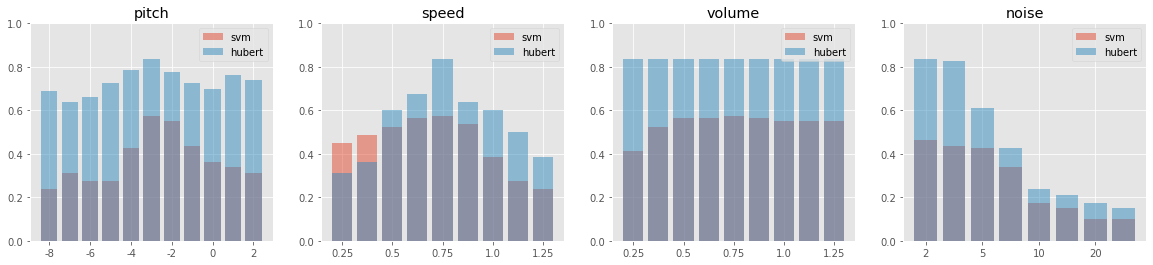

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
axs[0].bar(range(len(pitch_strengths)), svm_pitch_acc, label='svm', alpha=0.5)
axs[1].bar(range(len(speed_strengths)), svm_speed_acc, label='svm', alpha=0.5)
axs[2].bar(range(len(volume_strengths)), svm_volume_acc, label='svm', alpha=0.5)
axs[3].bar(range(len(noise_strengths)), svm_noise_acc, label='svm', alpha=0.5)
axs[0].bar(range(len(pitch_strengths)), hubert_pitch_acc, label='hubert', alpha=0.5)
axs[1].bar(range(len(speed_strengths)), hubert_speed_acc, label='hubert', alpha=0.5)
axs[2].bar(range(len(volume_strengths)), hubert_volume_acc, label='hubert', alpha=0.5)
axs[3].bar(range(len(noise_strengths)), hubert_noise_acc, label='hubert', alpha=0.5)
axs[0].set_xticklabels(pitch_strengths)
axs[1].set_xticklabels(speed_strengths)
axs[2].set_xticklabels(volume_strengths)
axs[3].set_xticklabels(noise_strengths)
axs[0].set_title('pitch')
axs[1].set_title('speed')
axs[2].set_title('volume')
axs[3].set_title('noise')
axs[0].set_ylim(0, 1)
axs[1].set_ylim(0, 1)
axs[2].set_ylim(0, 1)
axs[3].set_ylim(0, 1)
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
plt.show()

How does the foundation model compare to the SVM in terms of robustness? What similarities and differences do you notice? In practice, if you had to choose one, which one would you prefer?

(Insert your answer here.)

# Are all foundation models good for all tasks?

Let's try a different foundation model that is typically used for speech generation, a different task than classifying sounds. It too is trained on a very large corpus of recorded speech. How will it compare?

In [ ]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model

device = torch.device('cuda')  # make sure GPU hardware is enabled!
# the pretrained
wav2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec_model = wav2vec_model.to(device)

def wav2vec_feature_fn(data, sr):
  return speech_foundation_feature_fn(data, wav2vec_processor, wav2vec_model, device=device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train and evaluate using Wav2Vec foundation features

We now create a training and evaluation setup as above, but using Wav2Vec features. Again this experiment uses the `kfold_pipeline` by defining a `train_fn` and a `predict_fn` for the model. You are welcome to try logistic regression or another supervised model to experiment with Wav2Vec features.  

_Expected results_: classifier performance using wav2vec features is more comparable to training directly with baseline features, and much lower accuracy than using HUBERT foundation features. It's okay if experiment and can't get Wav2Vec models to outperform those with HUBERT features. Remember that not all foundation models are equal --- you must pick one that is trained with relevant data and supervision for your task.

In [ ]:
def train_svm(X_train, y_train):
  model = LinearSVC()
  model.fit(X_train, y_train)
  return model

def predict_svm(model, X):
  return model.predict(X)

results, _ = kfold_pipeline(wav2vec_feature_fn, train_svm, predict_svm)
print(f'[wav2vec+SVM] Train Accuracy: {results["train_acc_avg"]} +- {results["train_acc_std"]}')
print(f'[wav2vec+SVM] Test Accuracy: {results["test_acc_avg"]} +- {results["test_acc_std"]}')


-- Starting fold: 1


100%|██████████| 80/80 [00:01<00:00, 54.51it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---- test acc: 0.6125
-- Starting fold: 2


100%|██████████| 80/80 [00:01<00:00, 53.80it/s]


---- test acc: 0.65
-- Starting fold: 3


100%|██████████| 80/80 [00:01<00:00, 53.14it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---- test acc: 0.65
-- Starting fold: 4


100%|██████████| 80/80 [00:01<00:00, 52.66it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---- test acc: 0.6
-- Starting fold: 5


100%|██████████| 80/80 [00:01<00:00, 50.51it/s]


---- test acc: 0.6125
[wav2vec+SVM] Train Accuracy: 0.95375 +- 0.005376453291901654
[wav2vec+SVM] Test Accuracy: 0.625 +- 0.020916500663351895


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
